## Gomory–Hu tree

The __Gomory–Hu__ tree of an undirected graph $G$ with capacities on its edges is a weighted tree that represents the minimum $s$-$t$ cuts for all pairs of vertices $s$, $t$ in the graph $G$. See for example [Wikipedia](https://en.wikipedia.org/wiki/Gomory%E2%80%93Hu_tree) for more details.

##### Definition:

Let $G$ be an undirected graph with edge capacities $c_G(u, v)$, $uv \in E(G)$; let $\lambda_{st}$ be the capacity of minimal $s$-$t$ cut. 

A tree $T$ with $V(T) = V(G)$ is said to be a __Gomory-Hu__ tree of $G$ if for each $s, t \in V(G)$, $\lambda_{st} = \min_{uv \in P(s,t)}c_T(u,v)$, where $P(s,t)$ is a set of edges on the path between $s$ and $t$ in $T$.




Write a function `gomory_hu_tree(G)` which returns a Gomory-Hu tree of the graph G. Assume that G is connected.

#### Algorithm

Let `G` be the input graph and `T` the result (vertices of `T` are sets of vertices of `G`)

```
T = tree with single vertex V(G)
while there exists a vertex X of T with |X| >= 2:
    choose s and t from X
    calculate minimal s-t cut in G with partition sets A, B (s in A, t in B), cut edges E, and value c
    split vertex X to X1 = X ∩ A and X2 = X ∩ B and connect them with edge with weight (label) c
    for each neighbor Y of X in T:
        if Y ⊂ A: add edge (X1, Y) to T, else: add edge (X2, Y) to T
    modify G as follows:
     1. remove all (cut) edges E between A and B
     2. add new vertex and connect it to the endpoints of cut edges E in A and B
        (pay attention that you sum capacities if you "merge" two or more edges into one)       
```

#### Notes and examples

In [1]:
G = Graph([(0, 1, 1), (0, 2, 7), (1, 2, 1), (1, 3, 3), (1, 4, 2), (2, 4, 4), (3, 4, 1), (3, 5, 6), (4, 5, 2)])

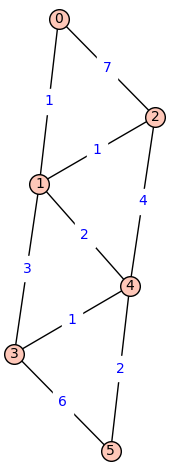

In [2]:
G.plot(edge_labels=True)

To calculate minimal edge cut, we can use Ford-Fulkerson algorithm. We will use built-in `edge_cut` function. 
Example for the graph above for $s$ = 0 and $t$ = 5:

In [3]:
G.edge_cut(0, 5, use_edge_labels=True)

6

To get more data (edges of the cut and the two sets separating 0 and 5) use:

In [4]:
cut, ce, AB = G.edge_cut(0, 5, vertices=True, use_edge_labels=True)

In [5]:
AB

[[0, 2], [1, 3, 4, 5]]

In [6]:
ce

[(0, 1, 1), (1, 2, 1), (2, 4, 4)]

In [7]:
def gomory_hu_tree(G0):
    # Make a copy, since we will change G!
    G = G0.copy()
    # A vertex of the tree must be a tuple (tuple is "hashable" while G.vertices() is
    # a list which is a non-hashable object and can not be used as a vertex label in Sage)
    X = tuple(G.vertices())  
    T = Graph({X: []})
    while len(X) >= 2:
        # choose any two elements from X for s and t
        s = X[0]
        t = X[1]
        value, cut_edges, partition = G.edge_cut(s, t, vertices=True, use_edge_labels=True)
        A = set(partition[0])
        B = set(partition[1])
        X1 = tuple(set(X) & A)
        X2 = tuple(set(X) & B)
        T.add_vertices([X1, X2])
        
        # connect the neighbors of X to either X1 or X2 according to the rule in the algorithm
        for Y in T.neighbors(X):
            if set(Y).issubset(A):
                T.add_edge(X1, Y, T.edge_label(X, Y))
            else:
                T.add_edge(X2, Y, T.edge_label(X, Y))
                
        # remove the vertex X and add edge between the two new vertices X1, X2
        T.delete_vertex(X)
        T.add_edge(X1, X2, value)
        
        # modify the current graph: add new vertex, remove cut edges and connect them to the new vertex
        w = G.add_vertex() # we let Sage to give a name to the new vertex
        wc = {} # capacities of new edges to w
        for u, v, c in cut_edges:
            G.delete_edge(u, v)  # remove cut edge
            # new edges will be (u, w) and (v, w)            
            if u in wc:
                # if we already handled edge from u to w, just increase (sum) the capacity ...
                wc[u] += c
            else: 
                # ... otherwise add new element to wc with capacity c
                wc[u] = c
            # same for the other end of cut edge, v
            if v in wc:
                wc[v] += c
            else:
                wc[v] = c
                
        # add edges to new vertex w
        for x, c in wc.items():
            G.add_edge(x, w, c)
        
        # choose a vertex in T with max size for new X 
        # (it would be sufficient to find the first one with len >= 2)
        X = max(T.vertices(), key=lambda v: len(v))
       
    # We re-label vertices at the end
    # Vertices of T are here tuples with one element, but we want them to be elements of 
    # the original graph
    T.relabel(dict([(X, X[0]) for X in T.vertices()]))
    return T

In [8]:
GT = gomory_hu_tree(G)

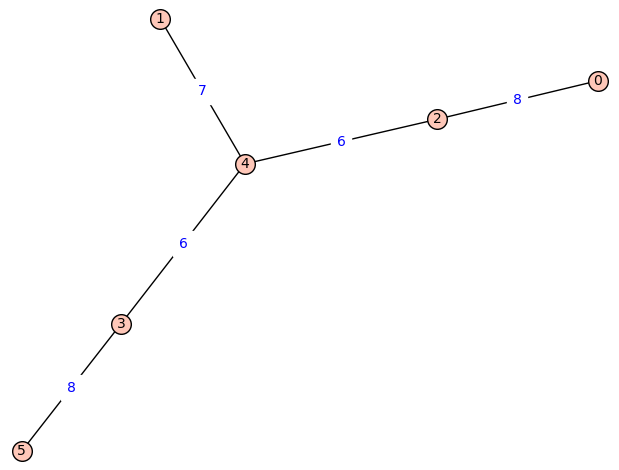

In [9]:
GT.plot(edge_labels=True)

In [10]:
def min_cut_from_tree(T, s, t):
    P = T.shortest_path(s, t)
    return min([T.edge_label(P[i], P[i + 1]) for i in range(len(P) - 1)])

In [11]:
[(u, v, min_cut_from_tree(GT, u, v), G.edge_cut(u, v, use_edge_labels=True)) for v in G.vertices() for u in G.vertices() if u < v]

[(0, 1, 6, 6),
 (0, 2, 8, 8),
 (1, 2, 6, 6),
 (0, 3, 6, 6),
 (1, 3, 6, 6),
 (2, 3, 6, 6),
 (0, 4, 6, 6),
 (1, 4, 7, 7),
 (2, 4, 6, 6),
 (3, 4, 6, 6),
 (0, 5, 6, 6),
 (1, 5, 6, 6),
 (2, 5, 6, 6),
 (3, 5, 8, 8),
 (4, 5, 6, 6)]

### More tests

In [12]:
def add_random_weights(G, minw, maxw):
    for u, v in G.edges(labels=False):
        G.add_edge(u, v, randint(minw, maxw))
    return G

In [13]:
C = add_random_weights(graphs.CycleGraph(10), 1, 10)

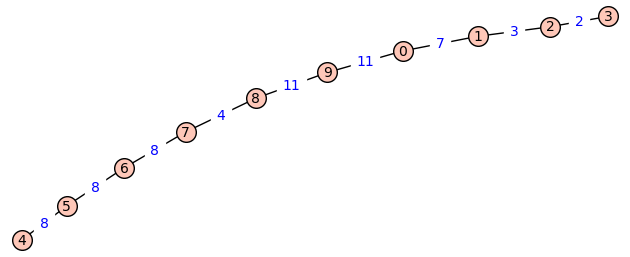

In [14]:
CT = gomory_hu_tree(C)
CT.plot(edge_labels=True)

In [15]:
[(u, v, min_cut_from_tree(CT, u, v), C.edge_cut(u, v, use_edge_labels=True)) for v in C.vertices() for u in C.vertices() if u < v]

[(0, 1, 7, 7),
 (0, 2, 3, 3),
 (1, 2, 3, 3),
 (0, 3, 2, 2),
 (1, 3, 2, 2),
 (2, 3, 2, 2),
 (0, 4, 4, 4),
 (1, 4, 4, 4),
 (2, 4, 3, 3),
 (3, 4, 2, 2),
 (0, 5, 4, 4),
 (1, 5, 4, 4),
 (2, 5, 3, 3),
 (3, 5, 2, 2),
 (4, 5, 8, 8),
 (0, 6, 4, 4),
 (1, 6, 4, 4),
 (2, 6, 3, 3),
 (3, 6, 2, 2),
 (4, 6, 8, 8),
 (5, 6, 8, 8),
 (0, 7, 4, 4),
 (1, 7, 4, 4),
 (2, 7, 3, 3),
 (3, 7, 2, 2),
 (4, 7, 8, 8),
 (5, 7, 8, 8),
 (6, 7, 8, 8),
 (0, 8, 11, 11),
 (1, 8, 7, 7),
 (2, 8, 3, 3),
 (3, 8, 2, 2),
 (4, 8, 4, 4),
 (5, 8, 4, 4),
 (6, 8, 4, 4),
 (7, 8, 4, 4),
 (0, 9, 11, 11),
 (1, 9, 7, 7),
 (2, 9, 3, 3),
 (3, 9, 2, 2),
 (4, 9, 4, 4),
 (5, 9, 4, 4),
 (6, 9, 4, 4),
 (7, 9, 4, 4),
 (8, 9, 11, 11)]

In [16]:
R = add_random_weights(graphs.RandomGNP(10, 0.5), 1, 10)

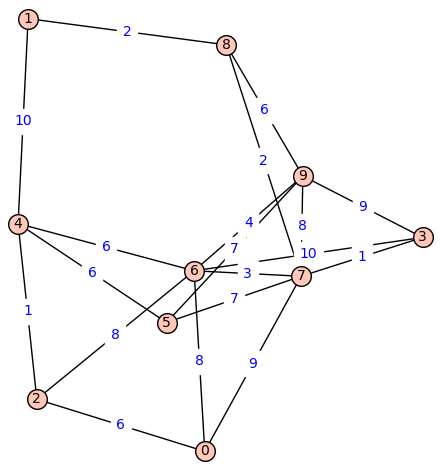

In [17]:
R.plot(edge_labels=True)

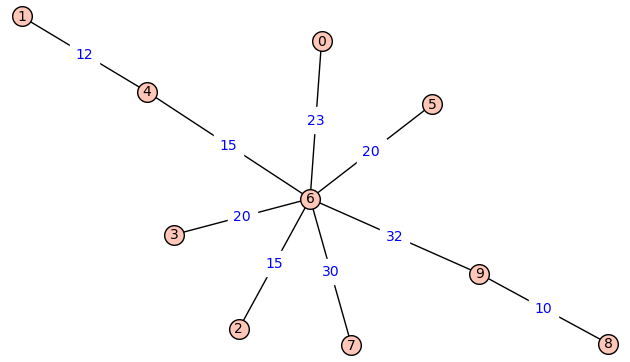

In [18]:
RT = gomory_hu_tree(R)
RT.plot(edge_labels=True)

In [19]:
[(u, v, min_cut_from_tree(RT, u, v), R.edge_cut(u, v, use_edge_labels=True)) for v in R.vertices() for u in R.vertices() if u < v]

[(0, 1, 12, 12),
 (0, 2, 15, 15),
 (1, 2, 12, 12),
 (0, 3, 20, 20),
 (1, 3, 12, 12),
 (2, 3, 15, 15),
 (0, 4, 15, 15),
 (1, 4, 12, 12),
 (2, 4, 15, 15),
 (3, 4, 15, 15),
 (0, 5, 20, 20),
 (1, 5, 12, 12),
 (2, 5, 15, 15),
 (3, 5, 20, 20),
 (4, 5, 15, 15),
 (0, 6, 23, 23),
 (1, 6, 12, 12),
 (2, 6, 15, 15),
 (3, 6, 20, 20),
 (4, 6, 15, 15),
 (5, 6, 20, 20),
 (0, 7, 23, 23),
 (1, 7, 12, 12),
 (2, 7, 15, 15),
 (3, 7, 20, 20),
 (4, 7, 15, 15),
 (5, 7, 20, 20),
 (6, 7, 30, 30),
 (0, 8, 10, 10),
 (1, 8, 10, 10),
 (2, 8, 10, 10),
 (3, 8, 10, 10),
 (4, 8, 10, 10),
 (5, 8, 10, 10),
 (6, 8, 10, 10),
 (7, 8, 10, 10),
 (0, 9, 23, 23),
 (1, 9, 12, 12),
 (2, 9, 15, 15),
 (3, 9, 20, 20),
 (4, 9, 15, 15),
 (5, 9, 20, 20),
 (6, 9, 32, 32),
 (7, 9, 30, 30),
 (8, 9, 10, 10)]